# Tic - Toc 

In [1]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

# Synthetic Example

The input data is the noisy data, while the target is the clean data. Here, the DDAE works in a supervised way to reconstruct the clean data from the noisy data.

In [36]:

from keras.layers import Input, Dense, Dropout, concatenate, UpSampling1D, Flatten, MaxPooling1D, BatchNormalization, average
from keras.models import Model
import scipy.io
from keras import optimizers
from keras import backend as K
from tensorflow.python.keras import backend as KK
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras import regularizers

import theano
import theano.tensor as T
import tensorflow as tf
import numbers
from tensorflow.python.framework import ops
from tensorflow.python.ops import standard_ops
from math import*
import theano.tensor as T

import numpy as np
import matplotlib.pyplot as plt

#corr1=0.03
#corr2=0.98
#corr3=0.87

#corr1=0.015
#corr2=0.790
#corr3=0.620


corr1=0
corr2=1
corr3=1
win = 256

mat = scipy.io.loadmat ('./DDAE_SYN.mat')
dataNoise = mat['dn'] 
dataNoise = np.transpose(dataNoise)
dataNoise = np.reshape(dataNoise,(256,int(np.shape(dataNoise)[0]*np.shape(dataNoise)[1]/win )))
dataNoise = np.transpose(dataNoise)
dataNoise = np.reshape(dataNoise, (dataNoise.shape[0],dataNoise.shape[1]))

dataNoise1= mat['d']
dataNoise1 = np.transpose(dataNoise1)
dataNoise1 = np.reshape(dataNoise1,(256,int(np.shape(dataNoise1)[0]*np.shape(dataNoise1)[1]/256 )))
dataNoise1 = np.transpose(dataNoise1)
dataNoise1 = np.reshape(dataNoise1, (dataNoise1.shape[0],dataNoise1.shape[1]))


INPUT_SIZE1 = dataNoise.shape[0]
INPUT_SIZE2 = dataNoise.shape[1]
 
input_img = Input(shape=(INPUT_SIZE2,))


encoded1 = Dense(512, activation='relu')(input_img)
encoded2 = Dense(256, activation='relu')(encoded1)
encoded3 = Dense(128, activation='relu' )(encoded2)


decoded1 = Dense(128, activation='relu' )(encoded3)
decoded2 = Dense(256, activation='relu')(decoded1)
decoded3 = Dense(512, activation='relu' )(decoded2)


decoded = Dense(INPUT_SIZE2, activation='linear')(decoded3)


autoencoder = Model(input_img, decoded)
sgd = optimizers.adam(lr=0.001)
autoencoder.compile(optimizer=sgd, loss='mse')

autoencoder.summary()


batch =64

tic()
history = autoencoder.fit(dataNoise,dataNoise1, epochs=50, batch_size=batch, shuffle=True)
toc()



Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 256)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_121 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_122 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_123 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_124 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_125 (Dense)            (None, 512)               131

# Plotting the Synthetic Example



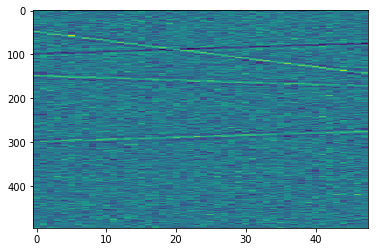

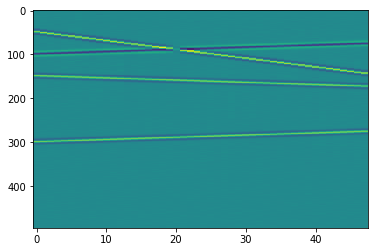

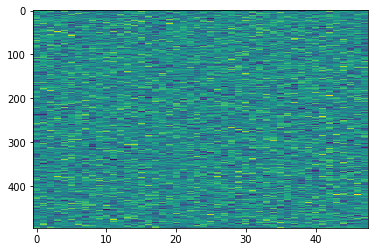

In [37]:

mat = scipy.io.loadmat ('./DDAE_SYN.mat')
dataNoise = mat['dn'] 
dataNoise = np.transpose(dataNoise)
dataNoise = np.reshape(dataNoise,(256,int(np.shape(dataNoise)[0]*np.shape(dataNoise)[1]/win )))
dataNoise = np.transpose(dataNoise)
dataNoise = np.reshape(dataNoise, (dataNoise.shape[0],dataNoise.shape[1]))
out = autoencoder.predict(dataNoise)

dataNoise = mat['dn'] 
dataNoise = np.transpose(dataNoise)
out = np.transpose(out)
out = np.reshape(out,(np.shape(dataNoise)[0], np.shape(dataNoise)[1])) 
plt.imshow(np.transpose(dataNoise), aspect = 'auto')
plt.figure() 
plt.imshow(np.transpose(out), aspect = 'auto')
plt.figure()
plt.imshow(np.transpose(dataNoise) - np.transpose(out), aspect = 'auto')

# Saving the DDAE Parameters as Json file 


In [38]:
from keras.models import model_from_json
from keras.models import load_model

model_json = autoencoder.to_json()
with open("bestInitial_syn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights("bestInitial_synW.h5")
print("Saved model to disk")

Saved model to disk


# Loading the DDAE Parameters for the Initialization of the Field Model. 


In [39]:
from keras.models import model_from_json
from keras.models import load_model

# load json and create model
json_file = open('bestInitial_syn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
DDAE = model_from_json(loaded_model_json)

# load weights into new model
DDAE.load_weights("bestInitial_synW.h5")
print("Loaded model from disk")

Loaded model from disk


# Field Example

The input data is noisy data. Here, the DDAE works in an unsupervised way by utilizing the customize loss function (cross-correlation loss function). The DDAE parameters have been initialized using the parameters obtained by the synthetic example.

In [45]:
from keras.layers import Input, Dense, Dropout, concatenate, UpSampling1D, Flatten, MaxPooling1D, BatchNormalization, Average, Lambda, Conv1D,LeakyReLU
from keras.models import Model
import scipy.io
from keras import optimizers
from keras import backend as K
from tensorflow.python.keras import backend as KK
from keras.callbacks import EarlyStopping
import tensorflow as tf
import numbers
from tensorflow.python.framework import ops
from tensorflow.python.ops import standard_ops
from math import*
import numpy as np
import matplotlib.pyplot as plt



corr1=0
corr2=1
corr3=1
mat = scipy.io.loadmat ('./NEWREAL3_1.mat')
dataNoise = mat['dn1'] 
dataNoise = np.transpose(dataNoise)
dataNoise = np.reshape(dataNoise, (dataNoise.shape[0],dataNoise.shape[1]))

INPUT_SIZE1 = dataNoise.shape[0]
INPUT_SIZE2 = dataNoise.shape[1]

 
input_img = Input(shape=(INPUT_SIZE2,))


# Encoder
encoded1 = Dense(512, activation = 'relu')(input_img)
encoded2 = Dense(256, activation = 'relu')(encoded1)
encoded3 = Dense(128, activation = 'relu')(encoded2)

# Decoder
decoded1 = Dense(128, activation = 'relu')(encoded3)
decoded2 = Dense(256, activation = 'relu')(decoded1)
decoded3 = Dense(512, activation = 'relu')(decoded2)

# Final Layer
decoded = Dense(INPUT_SIZE2, activation='linear')(decoded3)




def correlation_coefficient_loss(y_true, y_pred):
    #optional
    #x = y_true - y_pred
    #y = y_pred
    #mx = K.mean(x)
    #my = K.mean(y)
    #xm, ym = x-mx, y-my
    #r_num = K.sum(tf.multiply(xm,ym))
    #r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    #r = r_num / r_den
    #r =  corr1 - (K.maximum(K.minimum(r, 1.0), -1.0))
    
    #1
    x1 = y_true
    y1 = y_pred
    mx1 = K.mean(x1)
    my1 = K.mean(y1)
    xm1, ym1 = x1-mx1, y1-my1
    r_num1 = K.sum(tf.multiply(xm1,ym1))
    r_den1 = K.sqrt(tf.multiply(K.sum(K.square(xm1)), K.sum(K.square(ym1))))
    r1 = r_num1 / r_den1
    r1 = corr2 -  (K.maximum(K.minimum(r1, 1.0), -1.0))
    
    # Optional
    '''  
    x2 = y_true-y_pred
    y2 = y_true
    mx2 = K.mean(x2)
    my2 = K.mean(y2)
    xm2, ym2 = x2-mx2, y2-my2
    r_num2 = K.sum(tf.multiply(xm2,ym2))
    r_den2 = K.sqrt(tf.multiply(K.sum(K.square(xm2)), K.sum(K.square(ym2))))
    r2 = r_num2 / r_den2
    r2 =    corr3 - (K.maximum(K.minimum(r2, 1.0), -1.0))
    '''
    return   K.mean(K.square(y_true - y_pred)) + r1
        

                    

autoencoder = Model(input_img, decoded)
sgd = optimizers.adam(lr=0.001)
autoencoder.compile(optimizer=sgd, loss=[correlation_coefficient_loss])
#autoencoder.compile(optimizer=sgd, loss='mse')

autoencoder.summary()


batch =INPUT_SIZE2

# Initialization of the DDAE parameters using the parameters obtained by the synthetic example,
#in the paper we use more than one synthetich examples to obtain these parameters. However, here, 
#we just show the flow of the DDAE by using only one synthetic example. 

for i in range(2,7):
    w = DDAE.layers[i].get_weights()
    autoencoder.layers[i].set_weights(w)
    
tic()
history = autoencoder.fit(dataNoise,dataNoise, epochs=75, batch_size=batch, shuffle=True)
toc()



Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_141 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_142 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_143 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_144 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_145 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_146 (Dense)            (None, 512)               131

# Plotting the Field example.

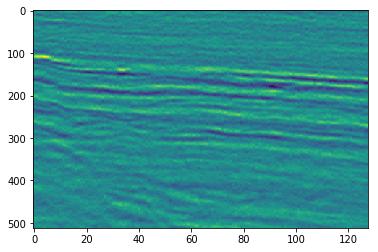

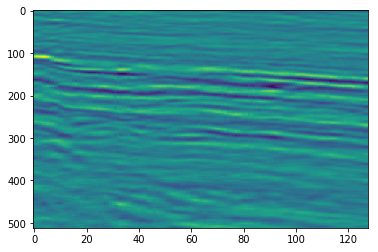

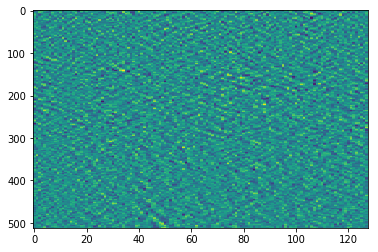

In [46]:
out = autoencoder.predict(dataNoise)
plt.imshow(np.transpose(dataNoise), aspect = 'auto')
plt.figure()
plt.imshow(np.transpose(out), aspect = 'auto')
plt.figure()
plt.imshow(np.transpose(dataNoise) - np.transpose(out ), aspect = 'auto')